In [5]:
import pandas as pd
from typing import List, Tuple, Dict, Any
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

In [6]:
url_restauration = "https://www.pxweb.bfs.admin.ch/sq/3c431fe1-16b0-4572-a8cd-ddbcfc919c5f"
url_population = "https://www.pxweb.bfs.admin.ch/sq/a2f3f03c-3b76-4dc0-890e-c6534d341848"

def restauration_employement_to_population_ratio(url_restauration : str, url_population : str) -> pd.DataFrame:
    df_restauration = pd.read_csv(url_restauration, encoding="ANSI")
    df_population = pd.read_csv(url_population, encoding="ANSI")
    df_population = df_population.groupby(["Année", "Sexe"], as_index=False)["Effectif au 1er janvier"].agg("sum")
    
    years : List[int] = [i for i in range(2010, 2025) for _ in range(8)]
    quarters : List[int] = [i for _ in range(15*2) for i in range(1, 5)]
    female : List[int] = [i for _ in range(15) for i in [1]*4+[0]*4]  # 1 if female, 0 if male
    indexes_of_columns_to_go : List[int] = [2+i for j in range((df_restauration.shape[1]-3)//4) for _ in range(2) for i in range(4*j+1, 4*j+5)] #to search efficiently in the dataframe for having the final datafram in the right format easily
    y : List[float] = []

    for index, gender, year in zip(indexes_of_columns_to_go, female, years):
        y.append(df_restauration.iloc[gender, index]/df_population.loc[df_population["Année"].eq(year)&df_population["Sexe"].eq("Femme" if gender==1 else "Homme"), "Effectif au 1er janvier"].iat[0]*100)

    dict : Dict[List[Any]] = {"Year" : years,
            "Quarter" : quarters,
            "Employment-to-population Ratio [%]" : y, 
            "Female" : female}
    return pd.DataFrame(dict)

def create_quarter_dummies(df : pd.DataFrame):
    quarter_lists_list = [[], [], [], []]
    for i in range(df.shape[0]):
        for j in range(1, 5):
            if df["Quarter"][i]==j:
                quarter_lists_list[j-1].append(1)
            else:
                quarter_lists_list[j-1].append(0)
    for i in range(4):
        df[f"Q{i+1}"]=quarter_lists_list[i]
    return df

def create_specific_quarter_dummies(df : pd.DataFrame, year : int, quarter : int) -> pd.DataFrame:
    dummy_list = []
    for i in range(df.shape[0]):
        if df["Year"][i]==year and df["Quarter"][i] == quarter:
            dummy_list.append(1)
        else:
            dummy_list.append(0)
    df[f"Y{year}Q{quarter}"] = dummy_list
    return df

def create_lockdown_dummies(df : pd.DataFrame, include_after : bool = False) -> pd.DataFrame:
    indexes = [i for i in range(80, 98)]
    if include_after:
        indexes.extend([i for i in range(98, df.shape[0])])
    else:
        indexes.extend([100, 101])
    dummy_list = [1 if i in indexes else 0 for i in range(df.shape[0])]
    df[f"{"After_" if include_after else "During_"}Lockdown"] = dummy_list
    return df

def dataframe_creator(url_restauration : str, url_population : str) -> pd.DataFrame:
    df = restauration_employement_to_population_ratio(url_restauration, url_population)
    df = create_quarter_dummies(df)
    df = create_lockdown_dummies(df)
    df = create_lockdown_dummies(df, True)
    for year, quarter in zip([2019, 2019, 2019, 2019, 2022, 2022, 2023, 2023], [4, 3, 2, 1, 3, 4, 1, 2]):
        df = create_specific_quarter_dummies(df, year, quarter) 
    return df

In [7]:
df = dataframe_creator(url_restauration, url_population)
df

,Year,Quarter,Employment-to-population Ratio [%],Female,Q1,Q2,Q3,Q4,During_Lockdown,After_Lockdown,Y2019Q4,Y2019Q3,Y2019Q2,Y2019Q1,Y2022Q3,Y2022Q4,Y2023Q1,Y2023Q2
0,2010,1,3.084915,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2010,2,3.088478,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2010,3,2.990922,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2010,4,2.972550,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2010,1,2.450227,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024,4,2.385542,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0
116,2024,1,2.494324,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
117,2024,2,2.441515,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
118,2024,3,2.564543,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [8]:
df.columns

Index(['Year', 'Quarter', 'Employment-to-population Ratio [%]', 'Female', 'Q1',
       'Q2', 'Q3', 'Q4', 'During_Lockdown', 'After_Lockdown', 'Y2019Q4',
       'Y2019Q3', 'Y2019Q2', 'Y2019Q1', 'Y2022Q3', 'Y2022Q4', 'Y2023Q1',
       'Y2023Q2'],
      dtype='object')

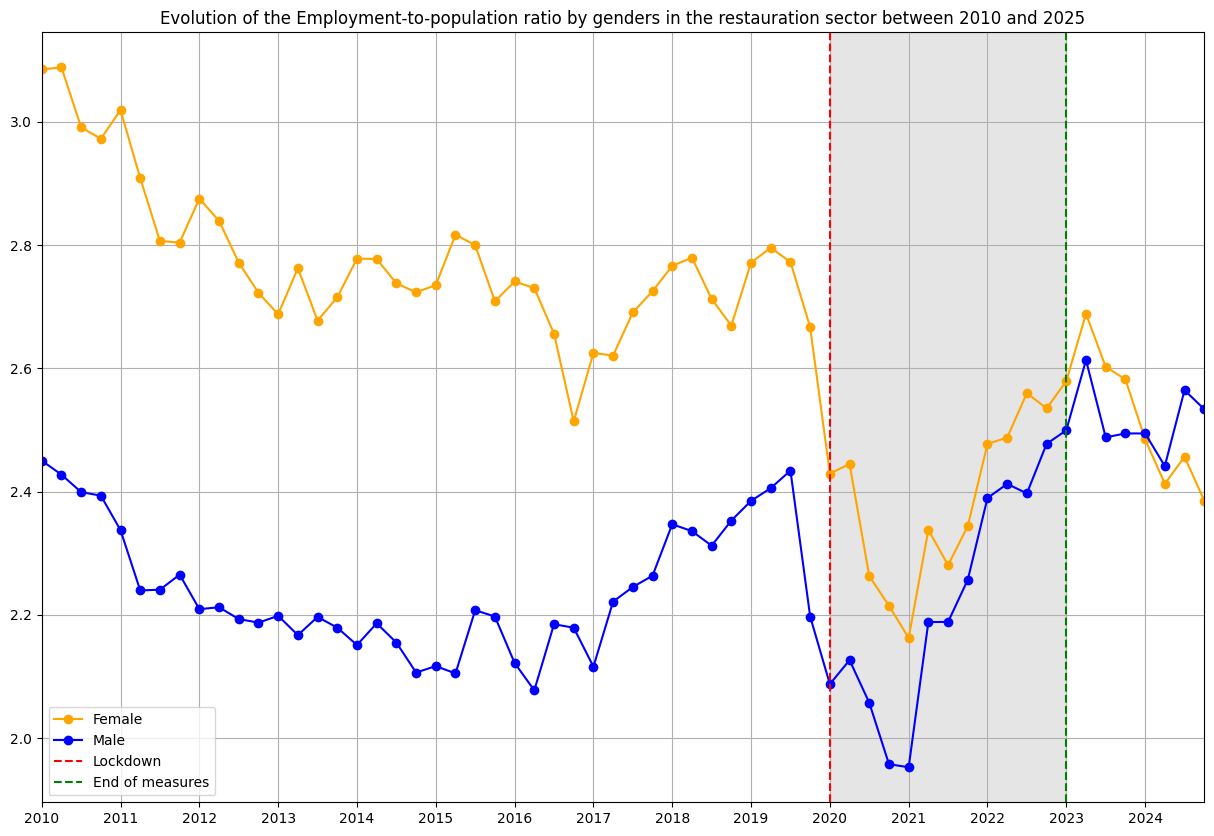

In [9]:
time = np.linspace(0, 59, 60)
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(time, df.loc[df["Female"]==1, "Employment-to-population Ratio [%]"], c="orange", marker="o", label="Female")
ax.plot(time, df.loc[df["Female"]==0, "Employment-to-population Ratio [%]"], c="blue", marker="o", label="Male")
ax.axvline(40, c="r", ls="--", label="Lockdown")
ax.axvline(52, c="green", ls="--", label="End of measures")
ax.axvspan(40, 52, color="grey", alpha=0.2)
plt.xlim(0, 59)
plt.xticks([i for i in time if i%4==0], labels=[f"20{10+i}" for i in range(15) for j in range(4) if j==0])
plt.legend()
plt.grid()
plt.title("Evolution of the Employment-to-population ratio by genders in the restauration sector between 2010 and 2025")
plt.show()

## DiDs

### Formulas

In [10]:
# DiDs
formula_did_a = r"Q('Employment-to-population Ratio [%]') ~ Female + After_Lockdown + Female:After_Lockdown"
formula_did_b = r"Q('Employment-to-population Ratio [%]') ~ Female + During_Lockdown + Female:During_Lockdown"
formula_did_quarter = r"Q('Employment-to-population Ratio [%]') ~ Female + During_Lockdown + Female:During_Lockdown + C(Quarter)"

In [11]:
simple_did = smf.ols(formula_did_a, data=df).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.739
Model:                                                 OLS   Adj. R-squared:                  0.732
Method:                                      Least Squares   F-statistic:                     149.9
Date:                                   ven., 12 déc. 2025   Prob (F-statistic):           9.51e-40
Time:                                             11:44:46   Log-Likelihood:                 69.769
No. Observations:                                      120   AIC:                            -131.5
Df Residuals:                                          116   BIC:                            -120.4
Df Model:                                                3                                         
Covariance Type:                                       HC1                                         


In [12]:
# formula_did = '''
# Q("Employment-to-population Ratio [%]") ~ Female + policy_period + Female:policy_period + C(Year) + C(Quarters)'''

simple_did = smf.ols(formula_did_b, data=df).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.706
Model:                                                 OLS   Adj. R-squared:                  0.699
Method:                                      Least Squares   F-statistic:                     88.48
Date:                                   ven., 12 déc. 2025   Prob (F-statistic):           7.51e-30
Time:                                             11:44:46   Log-Likelihood:                 62.619
No. Observations:                                      120   AIC:                            -117.2
Df Residuals:                                          116   BIC:                            -106.1
Df Model:                                                3                                         
Covariance Type:                                       HC1                                         


In [13]:
simple_did = smf.ols(formula_did_quarter, data=df).fit(cov_type="HC1")
print(simple_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.713
Model:                                                 OLS   Adj. R-squared:                  0.698
Method:                                      Least Squares   F-statistic:                     45.39
Date:                                   ven., 12 déc. 2025   Prob (F-statistic):           6.74e-28
Time:                                             11:44:46   Log-Likelihood:                 64.141
No. Observations:                                      120   AIC:                            -114.3
Df Residuals:                                          113   BIC:                            -94.77
Df Model:                                                6                                         
Covariance Type:                                       HC1                                         


## Event Studies

### Formulas

In [14]:
# formula_es_simple = r"Q('Employment-to-population Ratio [%]') ~ Female  + Y2019Q3 + Y2019Q4 + During_Lockdown + Y2022Q3 + Y2022Q4  + Female:Y2019Q3 + Female:Y2019Q2 + Female:During_Lockdown + Female:Y2022Q3 + Female:Y2022Q4"
# formula_es_heavier = r"Q('Employment-to-population Ratio [%]') ~ Female + C(Period, Treatment(reference=0)) + C(Quarter)"
formula_es_simple = r"Q('Employment-to-population Ratio [%]') ~ Female + Y2019Q4 + Y2019Q3 + Y2019Q2 + Y2019Q1 + During_Lockdown + Y2022Q3 + Y2022Q4 + Y2023Q1 + Y2023Q2 + Female:Y2019Q4 + Female:Y2019Q3 + Female:Y2019Q2 + Female:Y2019Q1 + Female:During_Lockdown + Female:Y2022Q3 + Female:Y2022Q4 + Female:Y2023Q1 + Female:Y2023Q2"
formula_es_heavier =formula_es_simple + " + C(Quarter)"

In [15]:
# formula_eventstudy = r'''Q("Employment-to-population Ratio [%]") ~ Female + C(Year) + C(Quarters) + C(event_time, Treatment(reference=-1)):Female'''
print(formula_es_simple)
eventstudy_did = smf.ols(formula_es_simple, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

Q('Employment-to-population Ratio [%]') ~ Female + Y2019Q4 + Y2019Q3 + Y2019Q2 + Y2019Q1 + During_Lockdown + Y2022Q3 + Y2022Q4 + Y2023Q1 + Y2023Q2 + Female:Y2019Q4 + Female:Y2019Q3 + Female:Y2019Q2 + Female:Y2019Q1 + Female:During_Lockdown + Female:Y2022Q3 + Female:Y2022Q4 + Female:Y2023Q1 + Female:Y2023Q2
                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.750
Model:                                                 OLS   Adj. R-squared:                  0.702
Method:                                      Least Squares   F-statistic:                     38.19
Date:                                   ven., 12 déc. 2025   Prob (F-statistic):           2.29e-19
Time:                                             11:44:46   Log-Likelihood:                 72.319
No. Observations:                                      120   AIC:                           

c:\Users\julie\anaconda3\envs\datascience_causalinference\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 4
  warnings.warn('covariance of constraints does not have full '


In [16]:
eventstudy_did = smf.ols(formula_es_heavier, data=df).fit(cov_type="HC1")
print(eventstudy_did.summary())

                                       OLS Regression Results                                      
Dep. Variable:     Q('Employment-to-population Ratio [%]')   R-squared:                       0.754
Model:                                                 OLS   Adj. R-squared:                  0.698
Method:                                      Least Squares   F-statistic:                     24.25
Date:                                   ven., 12 déc. 2025   Prob (F-statistic):           8.86e-19
Time:                                             11:44:46   Log-Likelihood:                 73.241
No. Observations:                                      120   AIC:                            -100.5
Df Residuals:                                           97   BIC:                            -36.37
Df Model:                                               22                                         
Covariance Type:                                       HC1                                         


c:\Users\julie\anaconda3\envs\datascience_causalinference\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 22, but rank is 7
  warnings.warn('covariance of constraints does not have full '
